
# Classification with Random Forrest

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from utils import *

In [2]:
preliminary_variables = ["disposition", "fine_amount","discount_amount", "judgment_amount", "compliance"]

In [3]:
df = pd.read_csv("train.csv",index_col="ticket_id", encoding = "ISO-8859-1",low_memory=False) 
df1= df[ preliminary_variables ].copy()
df1.dropna(inplace=True)

In [4]:
df_geoloc = df_geog_info(verbose=True)
df1 = df1.join(df_geoloc,how="left")
df1.dropna(inplace=True)

rows in df with addresses and ticketsID: 311307
rows after joining by address with latlon df: 266319
rows with merged info (lat,lon, address) after Nas dropped: 266316


In [5]:
#scalers_lat_lon = scale_lat_lon(df1)
#df1.drop(columns=["lat","lon"],inplace=True)

In [6]:
df1 = generate_street_zipcode(df1)
df1 = encode_categorical(df1)

Variable zip_code:
- 17666 unique values
- max. binary representation: 0b100010100000010
- binary-encoded generated features: 16

Variable street:
- 1696 unique values
- max. binary representation: 0b11010100000
- binary-encoded generated features: 12

Variable address:
- 64932 unique values
- max. binary representation: 0b1111110110100100
- binary-encoded generated features: 17



In [7]:
target = 'compliance'
features = df1.columns.drop(target)
X_train, X_test, y_train, y_test = train_test_split(df1[features], df1[target], random_state=0,train_size=0.85)

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Dataset with final features:

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117399 entries, 107479 to 116671
Data columns (total 54 columns):
fine_amount                     117399 non-null float64
discount_amount                 117399 non-null float64
judgment_amount                 117399 non-null float64
lat                             117399 non-null float64
lon                             117399 non-null float64
address_0                       117399 non-null int64
address_1                       117399 non-null int64
address_2                       117399 non-null int64
address_3                       117399 non-null int64
address_4                       117399 non-null int64
address_5                       117399 non-null int64
address_6                       117399 non-null int64
address_7                       117399 non-null int64
address_8                       117399 non-null int64
address_9                       117399 non-null int64
address_10                      117399 non-null int64
address_11

# Model development

In [9]:
#dictionary of class weights
class_weight = {}
for i in y_train.unique():
    class_weight[i] = np.ceil(100* np.sum(y_train==i) /len(y_train))
class_weight

{0.0: 94.0, 1.0: 7.0}

### A first try ....

In [10]:
%%time
#bootstrap true ensures that each subsample has the same size as the trainning set allowing replacement 
rf_clf = RandomForestClassifier(n_estimators=5, bootstrap=True, max_depth=3,min_samples_split=10,min_samples_leaf=5,
                      n_jobs=-1,random_state=0,class_weight=class_weight)
rf_clf.fit(X_train,y_train)
#y_train_pred = rf_clf.predict(X_train)y_test_pred = rf_clf.predict(X_test)
print("Train AUC score: {}".format(roc_auc_score(rf_clf.predict(X_train),y_train)))
print("Test AUC score: {}".format(roc_auc_score(rf_clf.predict(X_test),y_test)))

Train AUC score: 0.9662049199904466
Test AUC score: 0.9650331061814316
Wall time: 489 ms


In [11]:
print("Feature Importances:")
feature_importances= dict(zip(rf_clf.feature_importances_,X_train.columns.to_numpy()))
feature_importances[0.0] = "All the rest not shown"
feature_importances

Feature Importances:


{0.0: 'All the rest not shown',
 2.7105446622880483e-05: 'lat',
 4.747123810110245e-05: 'zip_code_2',
 6.687983602707283e-05: 'address_1',
 8.896874356588162e-05: 'zip_code_11',
 0.0002201403500001104: 'street_5',
 0.0006091420748572001: 'street_1',
 0.0010044686410029988: 'judgment_amount',
 0.0010469154556846543: 'address_8',
 0.0027649649185774302: 'address_3',
 0.003498762082919376: 'zip_code_10',
 0.011409804192552862: 'lon',
 0.0701118824527955: 'responsible_by_determination',
 0.14937730153806852: 'fine_amount',
 0.1630805340162775: 'responsible_by_deter',
 0.2266669271081013: 'responsible_by_default',
 0.36997873190484565: 'discount_amount'}

In [12]:
confusion_mat(y_pred=rf_clf.predict(X_test),y_true=y_test)

,Predicted 0,Predicted 1
True 0,19244,0
True 1,1447,27


## Cross-validation

In [13]:
important_features = [ feature_importances[i] for i in feature_importances if i>1e-3 ]
selected_features  = ['fine_amount', 'discount_amount', 'judgment_amount', 'lat', 'lon',
                     'responsible_by_deter', 'responsible_by_admission','responsible_by_default',
                     'responsible_by_determination']

parameters = {"n_estimators":[3,5,7,9,12,15], "max_depth":[2,3,5,7,9] , "min_samples_split":[10,50,100] , "min_samples_leaf": [1,10,50] }
model = RandomForestClassifier(n_jobs=-1,random_state=0,class_weight=class_weight,bootstrap=True)

### with AUC score

In [14]:
grid_clf = train_and_cross_validate(model,X_train[important_features],y_train,parameters,scoring="roc_auc")
print("best  score: {}".format(grid_clf.best_score_))
confusion_mat(y_true=y_test,y_pred=grid_clf.predict(X_test[important_features]))

--- 81.14177656173706 seconds ---
best  score: 0.7942398982901729


,Predicted 0,Predicted 1
True 0,19237,7
True 1,1264,210


### with Recall

In [15]:
grid_clf = train_and_cross_validate(model,X_train[selected_features],y_train,parameters,scoring="recall")
print("best score: {}".format(grid_clf.best_score_))
confusion_mat(y_true=y_test,y_pred=grid_clf.predict(X_test[selected_features]))

--- 86.89362812042236 seconds ---
best score: 0.1482624448476719


,Predicted 0,Predicted 1
True 0,19237,7
True 1,1291,183


<IPython.core.display.Javascript object>


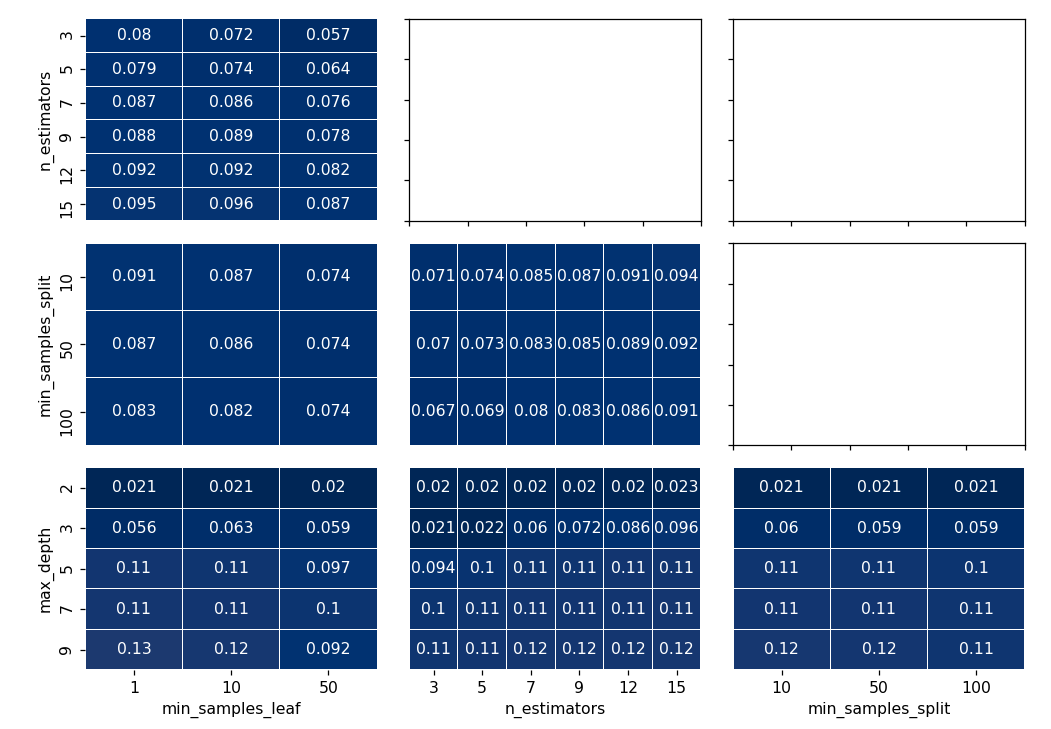

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set r

In [16]:
plot_cross_validation_results(parameters,grid_clf)

<IPython.core.display.Javascript object>


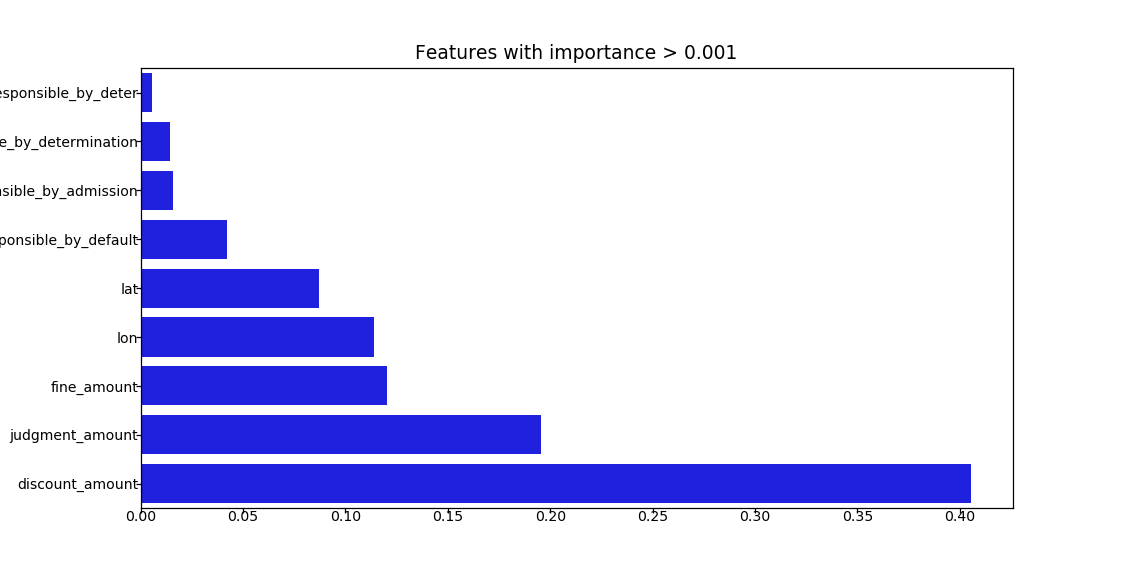

c:\users\c.lizarazosabogal\appdata\local\programs\python\python35\lib\site-packages\matplotlib\tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


(array([0.0056323 , 0.01420145, 0.01581316, 0.04215796, 0.08700338,
        0.11401448, 0.12022615, 0.19548862, 0.4054625 ]),
 array(['responsible_by_deter', 'responsible_by_determination',
        'responsible_by_admission', 'responsible_by_default', 'lat', 'lon',
        'fine_amount', 'judgment_amount', 'discount_amount'], dtype=object))

In [22]:
get_feature_importance(grid_clf,X_train[selected_features],threshold=0.1e-2,saveplot="")